Number of samples per class 1000
Shape of training data (3200, 50, 30, 20)
Shape of test data (800, 50, 30, 20)
Model: "3DCNN_MRI"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 30, 20, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 50, 30, 20, 64)    1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 25, 15, 10, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 25, 15, 10, 64)    110656    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 13, 8, 5, 64)     0         
 3D)                                                             
           

50/50 [==============================] - 1807s 36s/step - loss: 0.0512 - accuracy: 0.9806 - val_loss: 0.5964 - val_accuracy: 0.8475 - lr: 9.8361e-04

Epoch 00059: LearningRateScheduler setting learning rate to 0.0009830386077916997.
Epoch 59/100
50/50 [==============================] - 1810s 36s/step - loss: 0.0460 - accuracy: 0.9850 - val_loss: 0.5777 - val_accuracy: 0.8650 - lr: 9.8304e-04

Epoch 00060: LearningRateScheduler setting learning rate to 0.0009824589171767762.
Epoch 60/100
50/50 [==============================] - 1810s 36s/step - loss: 0.0315 - accuracy: 0.9894 - val_loss: 0.5469 - val_accuracy: 0.8838 - lr: 9.8246e-04

Epoch 00061: LearningRateScheduler setting learning rate to 0.000981869814162037.
Epoch 61/100
50/50 [==============================] - 1807s 36s/step - loss: 0.0417 - accuracy: 0.9856 - val_loss: 0.5401 - val_accuracy: 0.8750 - lr: 9.8187e-04

Epoch 00062: LearningRateScheduler setting learning rate to 0.0009812711826853301.
Epoch 62/100
50/50 [==========

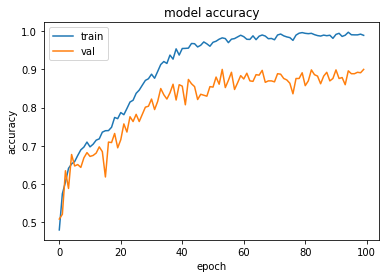

In [1]:
import random
import pickle
import tensorflow as tf
#from keras.optimizers import Adam
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential


from scipy import ndimage
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.layers.normalization import layer_normalization
from tensorflow.keras.optimizers import Adam 





X_train = pickle.load( open( "X1_train.pkl", "rb" ) )
X_test = pickle.load( open( "X1_test.pkl", "rb" ) )
ytrain = pickle.load( open( "y1train.pkl", "rb" ) )
ytest = pickle.load( open( "y1test.pkl", "rb" ) )

print('Number of samples per class %d' % 1000)
print('Shape of training data {}'.format(X_train.shape))
print('Shape of test data {}'.format(X_test.shape))
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

#Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, ytrain))
validation_loader = tf.data.Dataset.from_tensor_slices((X_test, ytest))

batch_size = 64
# Augment the on the fly during training.
train_dataset = (train_loader.shuffle(len(X_train)).map(train_preprocessing).batch(batch_size).prefetch(2))
# Only rescale.
validation_dataset = (validation_loader.shuffle(len(X_test)).map(validation_preprocessing).batch(batch_size).prefetch(2))
def model_3d(width=50, height=30, depth=20):
    """Build a 3D convolutional neural network model."""
    inputs = keras.Input((width, height, depth, 1))
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", strides=(1,1,1), padding='same')(inputs)
    x = layers.MaxPool3D(pool_size=3, strides=2, padding='same')(x)
    
    
    x = layers.Conv3D(filters=64, kernel_size=3, strides=(1,1,1), padding='same',activation="relu")(x)
    x = layers.MaxPool3D(pool_size=3,strides=2, padding='same')(x)
    
    
    x = layers.Conv3D(filters=128, kernel_size=3,strides=(1,1,1), activation="relu", padding='same')(x)
    x = layers.MaxPool3D(pool_size=3, strides=2,padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(units=10752, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(units=128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units=4, activation="softmax")(x)
    
    # Define the model.
    model = keras.Model(inputs, outputs, name="3DCNN_MRI")
    return model
#Build model.
model = model_3d(width=50, height=30, depth=20)
model.summary()


model.compile(loss="categorical_crossentropy", optimizer='Adam',metrics=["accuracy"],)
initial_learning_rate = 0.001
epochs = 100 

decay = initial_learning_rate / epochs
def lr_time_based_decay(epoch, lr):
  return lr*1 /(1+decay*epoch)

# Train the model, doing validation at the end of each epoch

history = model.fit(train_dataset, validation_data=validation_dataset, epochs=100, callbacks=[LearningRateScheduler(lr_time_based_decay, verbose=1)])
                                                                     
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



model.save('model.h5')


model = load_model('brandli_elenmis_batch_size_64.h5')

In [6]:
loss, acc = model.evaluate(X_test, ytest, verbose=0)


In [8]:
print(acc)  # 

0.8999999761581421


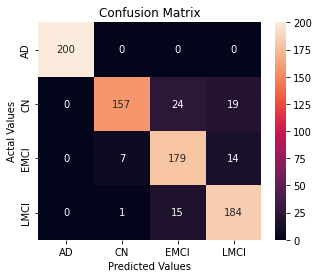

In [35]:
import pickle
from keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
X_test = pickle.load( open( "X1_test.pkl", "rb" ) )

y_test = pickle.load( open( "y1test.pkl", "rb" ) )

model = load_model('model.h5')
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
ytest = (np.argmax(y_test, axis=1)).reshape(-1,1)
ypred = (np.argmax(y_pred, axis=1)).reshape(-1,1)

cm =  confusion_matrix(ytest, ypred)
cm_df = pd.DataFrame(cm,
                     index = ['AD','CN','EMCI', 'LMCI'], 
                     columns = ['AD','CN','EMCI', 'LMCI'])
import seaborn as sns
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

25/25 [==============================] - 20s 796ms/step - loss: 0.5588 - accuracy: 0.9000
0.8999999761581421


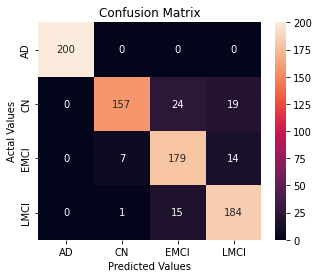

0.8999999761581421


,class,sensitivity,specificity
0,0,1.000000,1.000
1,1,0.986667,0.785
2,2,0.935000,0.895
3,3,0.945000,0.920


In [10]:
import keras
from keras import models
model = keras.models.load_model(r'model.h5')
import pickle
X_test = pickle.load( open( "X1_test.pkl", "rb" ) )

ytest = pickle.load( open( "y1test.pkl", "rb" ) )
loss, accuracy = model.evaluate(X_test, ytest)
print(accuracy)


from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
y_pred = model.predict(X_test)
ytest = (np.argmax(ytest, axis=1)).reshape(-1,1)
ypred = (np.argmax(np.round(y_pred), axis=1)).reshape(-1,1)
cm = confusion_matrix(ytest, ypred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['AD','CN','EMCI', 'LMCI'], 
                     columns = ['AD','CN','EMCI', 'LMCI'])

import seaborn as sns
import matplotlib.pyplot as plt
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
print(accuracy)



from sklearn.metrics import precision_recall_fscore_support
res = []
for l in [0,1,2,3]:
     prec,recall,_,_ = precision_recall_fscore_support(np.array(ytest)==l,
                                                  np.array(ypred)==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])




In [12]:
from sklearn.metrics import classification_report
report = classification_report(ytest, ypred)#this line gives everything. these are the evaluation metrics used. I am sorry . I don't know about. I want to get the sensitivity value and specifity value?

print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.95      0.79      0.86       200
           2       0.82      0.90      0.86       200
           3       0.85      0.92      0.88       200

    accuracy                           0.90       800
   macro avg       0.91      0.90      0.90       800
weighted avg       0.91      0.90      0.90       800

